[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana6/1_ValuacionOpciones_Black_Scholes.ipynb)

# Valuación de Opciones

En esta sesión aprenderemos a utilizar una fórmula matemática, conocida como Black-Scholes, para dar un precio a nuestras opciones (tipo Call Europeo).

Una Call Europeo es un contrato en el cual se pacta la posibilidad de comprar cierta cantidad de activos en el futuro, pero al precio que se establece actualmente.


Ejemplo:

Las acciones de Google cuestan \$100, yo veo que Google dice "Págame \$3 y en 30 días te vendo la acción a \$110" o "Págame \$5 y en 30 días te vendo la acción a \$100".

- Si no decido comprar el contrato no pasa nada.

- Si decido comprar el contrato hay dos posibilidades:
  - Si veo que en 30 días la acción cotiza a \$120, ejerzo el contrato y la compro a \$110
  - Si veo que en 30 días la acción cotiza a \$90, no ejerzo el contrato y mejor la compro directamente del mercado
  - Si en 30 días la acción sigue cotizando en \$110, ejercer el contrato o comprarla directamente da igual

El precio de una opción se modela como la solución de una ecuación diferencial parcial parabólica, que describe el precio de una opción en el tiempo:

$$ \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0. $$

Donde $S$ es el precio del activo subyacente de la opción. El problema tiene las condiciones de frontera:

$$
C(0, t) = 0\text{ for all }t \\
C(S, t) \rightarrow S - K \text{ as }S \rightarrow \infty \\
C(S, T) = \max\{S - K, 0\}
$$


* La valuación también funciona para Put Europeo.

## Ejercicio 1:


¿Que interpretación tienen las condiciones de frontera? Piensenlo y comentenlo con la clase

## Ejercicio 2:
¿Porqué comprar Opciones en lugar de Activos? ¿Ventajas y desventajas?

In [ ]:
#!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm

Los tickers a usar son:

- GOOGL: Acción de Google

- ^IRX: Treasury bills a 13 semanas

In [ ]:
data = yf.download(
        # Lista de tickers o puede ser un string
        tickers = "GOOGL ^IRX",

        # Parámetro "period", tambien se puede utilizar start/end
        # periodos válidos: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (opcional, default es '1mo')
        period = "1y",

        # Peidr datos por intervalo (incluye intradía si es menor a 60 days)
        # intervalos válidos: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (opcional, default es '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (opcional, default es 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
data

[*********************100%%**********************]  2 of 2 completed


Ticker,GOOGL,^IRX
Date,,
2023-05-15,116.510002,5.000
2023-05-16,119.510002,5.058
2023-05-17,120.839996,5.088
2023-05-18,122.830002,5.125
2023-05-19,122.760002,5.085
...,...,...
2024-05-08,169.380005,5.245
2024-05-09,169.960007,5.240
2024-05-10,168.649994,5.243


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.GOOGL

Date
2023-05-15    116.510002
2023-05-16    119.510002
2023-05-17    120.839996
2023-05-18    122.830002
2023-05-19    122.760002
                 ...    
2024-05-08    169.380005
2024-05-09    169.960007
2024-05-10    168.649994
2024-05-13    169.139999
2024-05-14    170.339996
Name: GOOGL, Length: 252, dtype: float64

In [ ]:
data['GOOGL']

Date
2023-05-15    116.510002
2023-05-16    119.510002
2023-05-17    120.839996
2023-05-18    122.830002
2023-05-19    122.760002
                 ...    
2024-05-08    169.380005
2024-05-09    169.960007
2024-05-10    168.649994
2024-05-13    169.139999
2024-05-14    170.339996
Name: GOOGL, Length: 252, dtype: float64

In [ ]:
data.^IRX

SyntaxError: invalid syntax (<ipython-input-5-5471dc925234>, line 1)

In [ ]:
data['^IRX']

Date
2023-05-15    5.000
2023-05-16    5.058
2023-05-17    5.088
2023-05-18    5.125
2023-05-19    5.085
              ...  
2024-05-08    5.245
2024-05-09    5.240
2024-05-10    5.243
2024-05-13    5.240
2024-05-14    5.235
Name: ^IRX, Length: 252, dtype: float64

In [ ]:
# Renombrar columna
data.rename(columns={'^IRX':'IRX'}, inplace=True)

In [ ]:
data.IRX

Date
2023-05-15    5.000
2023-05-16    5.058
2023-05-17    5.088
2023-05-18    5.125
2023-05-19    5.085
              ...  
2024-05-08    5.245
2024-05-09    5.240
2024-05-10    5.243
2024-05-13    5.240
2024-05-14    5.235
Name: IRX, Length: 252, dtype: float64

In [ ]:
data['IRX']

Date
2023-05-15    5.000
2023-05-16    5.058
2023-05-17    5.088
2023-05-18    5.125
2023-05-19    5.085
              ...  
2024-05-08    5.245
2024-05-09    5.240
2024-05-10    5.243
2024-05-13    5.240
2024-05-14    5.235
Name: IRX, Length: 252, dtype: float64

In [ ]:
# Convertir un porcentaje a número
data['IRX'] = data['IRX']/100

In [ ]:
data

Ticker,GOOGL,IRX
Date,,
2023-05-15,116.510002,0.05000
2023-05-16,119.510002,0.05058
2023-05-17,120.839996,0.05088
2023-05-18,122.830002,0.05125
2023-05-19,122.760002,0.05085
...,...,...
2024-05-08,169.380005,0.05245
2024-05-09,169.960007,0.05240
2024-05-10,168.649994,0.05243


In [ ]:
# Calculo de log-retornos
data['Vol. GOOGL'] = np.nan
data['log_ret'] = np.log(data['GOOGL']) - np.log(data['GOOGL'].shift(1))

In [ ]:
data

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2023-05-15,116.510002,0.05000,NaN,NaN
2023-05-16,119.510002,0.05058,NaN,0.025423
2023-05-17,120.839996,0.05088,NaN,0.011067
2023-05-18,122.830002,0.05125,NaN,0.016334
2023-05-19,122.760002,0.05085,NaN,-0.000570
...,...,...,...,...
2024-05-08,169.380005,0.05245,NaN,-0.010980
2024-05-09,169.960007,0.05240,NaN,0.003418
2024-05-10,168.649994,0.05243,NaN,-0.007738


<Axes: >

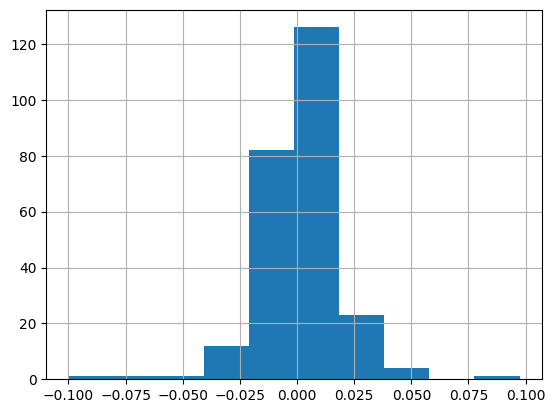

In [ ]:
data.log_ret.hist()

In [ ]:
# Calculando la volatilidad de las acciones de GOOGLE
fechas_vol = data.index
for cada_fecha in fechas_vol[125:]:
    data_for_vol = fechas_vol[(cada_fecha - fechas_vol < pd.Timedelta(days=180)) & (cada_fecha - fechas_vol >= pd.Timedelta(days=0))] # 120 dias para 6 meses
    data.loc[cada_fecha, 'Vol. GOOGL'] = np.std(data['log_ret'][data_for_vol].values, ddof=1)*np.sqrt(252)


In [ ]:
# Nuestros nuevos datos
data

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2023-05-15,116.510002,0.05000,NaN,NaN
2023-05-16,119.510002,0.05058,NaN,0.025423
2023-05-17,120.839996,0.05088,NaN,0.011067
2023-05-18,122.830002,0.05125,NaN,0.016334
2023-05-19,122.760002,0.05085,NaN,-0.000570
...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980
2024-05-09,169.960007,0.05240,0.292286,0.003418
2024-05-10,168.649994,0.05243,0.291427,-0.007738


<Axes: xlabel='Date'>

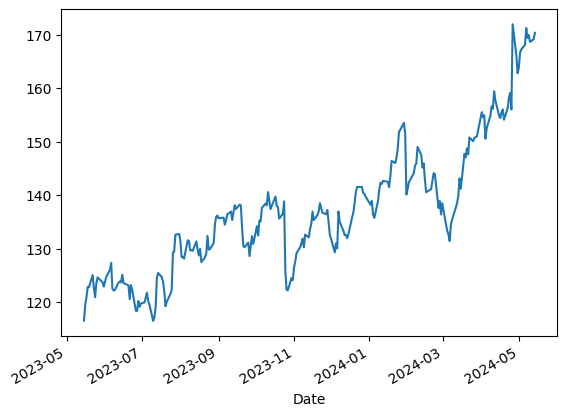

In [ ]:
data.GOOGL.plot()

In [ ]:
# Datos donde "Vol. GOOGL" deja de ser NULO
data[data['Vol. GOOGL'].notnull()]

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2023-11-13,132.089996,0.05260,0.278241,-0.003778
2023-11-14,133.619995,0.05253,0.277772,0.011516
2023-11-15,134.619995,0.05255,0.277933,0.007456
2023-11-16,136.929993,0.05243,0.277773,0.017014
2023-11-17,135.309998,0.05233,0.277249,-0.011901
...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980
2024-05-09,169.960007,0.05240,0.292286,0.003418
2024-05-10,168.649994,0.05243,0.291427,-0.007738


Al resolver la ecuación diferencial se llega la siguiente formula, que permite valuar el Call (suponiendo que no paga dividendos):

\begin{align}
  C(S_t, t) &= N(d_1)S_t - N(d_2)Ke^{-r(T - t)} \\
     d_1 &= \frac{1}{\sigma\sqrt{T - t}}\left[\ln\left(\frac{S_t}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T - t)\right] \\
     d_2 &= d_1 - \sigma\sqrt{T - t}. \\
\end{align}

Donde:

\begin{align}
t &: \mbox{tiempo} \\
S_t &: \mbox{Precio del activo al tiempo }t \\
K &: \mbox{Precio acordado en el contrato} \\
r &: \mbox{Tasa libre de riesgo}\\
\sigma^2 &: \mbox{Volatilidad del activo subyacente} \\
N(\cdot) &: \mbox{Función de distribución de la normal (probabilidad acumulada)}
\end{align}

In [ ]:
def ByS_call(spot, strike, risk_free, vol, tiempo):
    d_1 = (np.log(spot/strike) + (risk_free + 0.5*vol*vol)*(tiempo/360)) / (vol * np.sqrt(tiempo/360))
    d_2 = d_1 - vol*np.sqrt(tiempo/360)
    value = spot * norm.cdf(d_1) - strike * np.exp(-risk_free * (tiempo/360)) * norm.cdf(d_2)
    return value

In [ ]:
data

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2023-05-15,116.510002,0.05000,NaN,NaN
2023-05-16,119.510002,0.05058,NaN,0.025423
2023-05-17,120.839996,0.05088,NaN,0.011067
2023-05-18,122.830002,0.05125,NaN,0.016334
2023-05-19,122.760002,0.05085,NaN,-0.000570
...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980
2024-05-09,169.960007,0.05240,0.292286,0.003418
2024-05-10,168.649994,0.05243,0.291427,-0.007738


In [ ]:
un_dato = data.iloc[-1,:].copy()
un_dato

Ticker
GOOGL         170.339996
IRX             0.052350
Vol. GOOGL      0.292556
log_ret         0.007070
Name: 2024-05-14 00:00:00, dtype: float64

In [ ]:
tiempo_madurez = 30

In [ ]:
un_dato.GOOGL

170.33999633789062

In [ ]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL + 10, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

2.3949472683428965

In [ ]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL + 0, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

6.1032950900484195

In [ ]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL - 10, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

12.467560488046871

# Ejercicio 3
¿Que significa la salida de la función "ByS_call()"?

Respuesta: La prima a pagar por cada acción que quiera incluir en el contrato

# Ejemplo de método apply()

Creamos una función "lambda" (una función temporal) para aplicar una función a todos los datos del DataFrame.

Abajo, sumamos 2 columnas para crear una nueva llamada "columna_extra"

In [ ]:
ejercicio = data.copy()
ejercicio

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2023-05-15,116.510002,0.05000,NaN,NaN
2023-05-16,119.510002,0.05058,NaN,0.025423
2023-05-17,120.839996,0.05088,NaN,0.011067
2023-05-18,122.830002,0.05125,NaN,0.016334
2023-05-19,122.760002,0.05085,NaN,-0.000570
...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980
2024-05-09,169.960007,0.05240,0.292286,0.003418
2024-05-10,168.649994,0.05243,0.291427,-0.007738


In [ ]:
ejercicio.loc[:, 'columna_extra'] = data.apply(lambda x: x['GOOGL'] + x['Vol. GOOGL'], axis=1)
ejercicio

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret,columna_extra
Date,,,,,
2023-05-15,116.510002,0.05000,NaN,NaN,NaN
2023-05-16,119.510002,0.05058,NaN,0.025423,NaN
2023-05-17,120.839996,0.05088,NaN,0.011067,NaN
2023-05-18,122.830002,0.05125,NaN,0.016334,NaN
2023-05-19,122.760002,0.05085,NaN,-0.000570,NaN
...,...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980,169.673489
2024-05-09,169.960007,0.05240,0.292286,0.003418,170.252292
2024-05-10,168.649994,0.05243,0.291427,-0.007738,168.941421


## Otro modo de usar el método apply() al tener

In [ ]:
def func_duplicar(x1):
  return x1 + x1

In [ ]:
coso = data[['GOOGL']].copy()
coso

Ticker,GOOGL
Date,
2023-05-15,116.510002
2023-05-16,119.510002
2023-05-17,120.839996
2023-05-18,122.830002
2023-05-19,122.760002
...,...
2024-05-08,169.380005
2024-05-09,169.960007
2024-05-10,168.649994


In [ ]:
ejercicio.loc[:, 'col_extra'] = coso.apply(func_duplicar)

In [ ]:
ejercicio

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret,columna_extra,col_extra
Date,,,,,,
2023-05-15,116.510002,0.05000,NaN,NaN,NaN,233.020004
2023-05-16,119.510002,0.05058,NaN,0.025423,NaN,239.020004
2023-05-17,120.839996,0.05088,NaN,0.011067,NaN,241.679993
2023-05-18,122.830002,0.05125,NaN,0.016334,NaN,245.660004
2023-05-19,122.760002,0.05085,NaN,-0.000570,NaN,245.520004
...,...,...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980,169.673489,338.760010
2024-05-09,169.960007,0.05240,0.292286,0.003418,170.252292,339.920013
2024-05-10,168.649994,0.05243,0.291427,-0.007738,168.941421,337.299988


# Lista por comprensión

Se les ocurre un modo de utilizar listas por compresion en lugar de apply

¿Porque podría resultad conveniente esto?

In [ ]:
ejercicio = data.copy()

In [ ]:
%%time
ejercicio.loc[:, 'columna_extra'] = data.apply(lambda x: x['GOOGL'] + x['Vol. GOOGL'], axis=1)
ejercicio

CPU times: user 5.64 ms, sys: 0 ns, total: 5.64 ms
Wall time: 6.06 ms


Ticker,GOOGL,IRX,Vol. GOOGL,log_ret,columna_extra
Date,,,,,
2023-05-15,116.510002,0.05000,NaN,NaN,NaN
2023-05-16,119.510002,0.05058,NaN,0.025423,NaN
2023-05-17,120.839996,0.05088,NaN,0.011067,NaN
2023-05-18,122.830002,0.05125,NaN,0.016334,NaN
2023-05-19,122.760002,0.05085,NaN,-0.000570,NaN
...,...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980,169.673489
2024-05-09,169.960007,0.05240,0.292286,0.003418,170.252292
2024-05-10,168.649994,0.05243,0.291427,-0.007738,168.941421


In [ ]:
ejercicio2 = data.copy()

In [ ]:
%%time
# Con lista por comprensión
lista = [element[1]['GOOGL'] + element[1]['Vol. GOOGL'] for element in ejercicio2.iterrows()]
ejercicio2['nueva_col'] = lista

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 20.2 ms


In [ ]:
ejercicio2

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret,nueva_col
Date,,,,,
2023-05-15,116.510002,0.05000,NaN,NaN,NaN
2023-05-16,119.510002,0.05058,NaN,0.025423,NaN
2023-05-17,120.839996,0.05088,NaN,0.011067,NaN
2023-05-18,122.830002,0.05125,NaN,0.016334,NaN
2023-05-19,122.760002,0.05085,NaN,-0.000570,NaN
...,...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980,169.673489
2024-05-09,169.960007,0.05240,0.292286,0.003418,170.252292
2024-05-10,168.649994,0.05243,0.291427,-0.007738,168.941421


## Ejercicio 4

Quiten las columnas 'columna_extra' del DataFrame 'ejercicio', limpien los datos faltantes y después agreguen una columna con nombre "precio_de_calls" que tenga el precio del call en cada fila del DataFrame (sugerencia: usen un Strike que esté por encima del precio del activo en 10 unidades).

In [ ]:
# Espacio para ejercicio
ejercicio = ejercicio[ejercicio['Vol. GOOGL'].notnull()]
ejercicio

ejercicio.drop(columns=['columna_extra'], inplace=True)

<ipython-input-48-5c6d959fc843>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ejercicio.drop(columns=['columna_extra'], inplace=True)


In [ ]:
ejercicio

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2023-11-13,132.089996,0.05260,0.278241,-0.003778
2023-11-14,133.619995,0.05253,0.277772,0.011516
2023-11-15,134.619995,0.05255,0.277933,0.007456
2023-11-16,136.929993,0.05243,0.277773,0.017014
2023-11-17,135.309998,0.05233,0.277249,-0.011901
...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980
2024-05-09,169.960007,0.05240,0.292286,0.003418
2024-05-10,168.649994,0.05243,0.291427,-0.007738


In [ ]:
ejercicio['precio_de_calls'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], x['GOOGL'] + 10, x['IRX'], x['Vol. GOOGL'], 30), axis=1)


<ipython-input-50-e062afbd2be2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ejercicio['precio_de_calls'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], x['GOOGL'] + 10, x['IRX'], x['Vol. GOOGL'], 30), axis=1)


In [ ]:
ejercicio

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret,precio_de_calls
Date,,,,,
2023-11-13,132.089996,0.05260,0.278241,-0.003778,1.198248
2023-11-14,133.619995,0.05253,0.277772,0.011516,1.228304
2023-11-15,134.619995,0.05255,0.277933,0.007456,1.253432
2023-11-16,136.929993,0.05243,0.277773,0.017014,1.305560
2023-11-17,135.309998,0.05233,0.277249,-0.011901,1.261290
...,...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980,2.382944
2024-05-09,169.960007,0.05240,0.292286,0.003418,2.379726
2024-05-10,168.649994,0.05243,0.291427,-0.007738,2.328201


## Ejercicio 5

Visualice algún histograma de los precios de las opciones tipo Call Europeo

<Axes: >

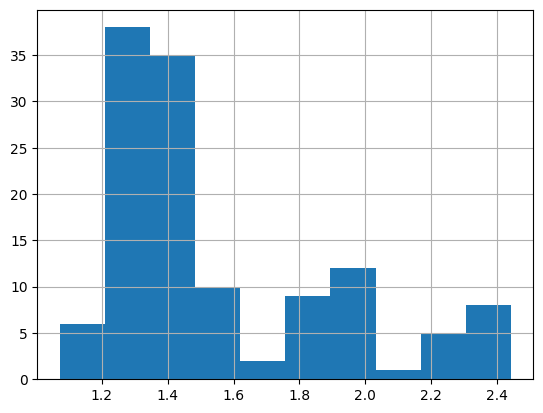

In [ ]:
# Espacio para ejercicio

ejercicio.precio_de_calls.hist()

Por último, solo ver como avanza el precio de los calls.

<Axes: xlabel='Date'>

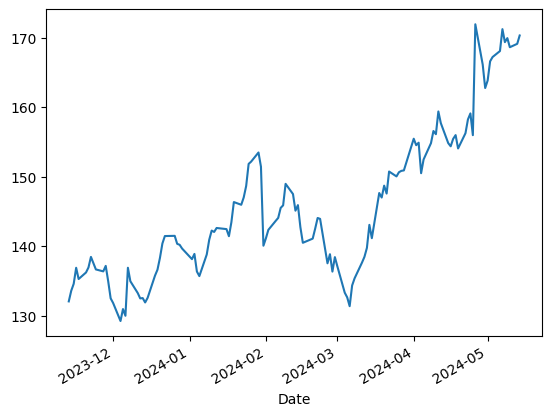

In [ ]:
ejercicio.GOOGL.plot()

<Axes: xlabel='Date'>

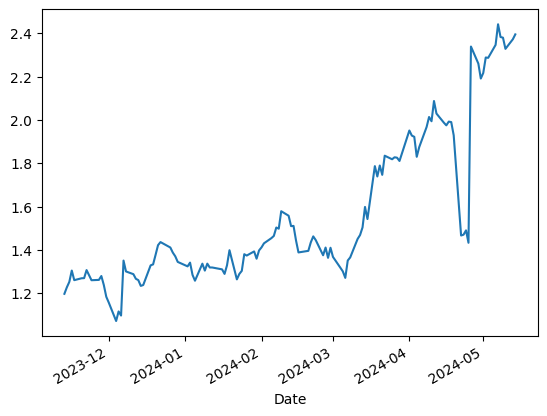

In [ ]:
ejercicio.precio_de_calls.plot()

In [ ]:
import matplotlib.pyplot as plt

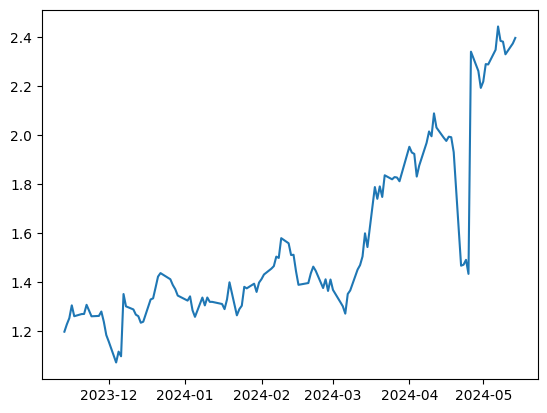

In [ ]:
# Se puede graficar utilizando directamente la función del módulo "Matplotlib"
plt.plot(ejercicio.precio_de_calls)
plt.show()

# Ejercicio:

1.- Escoger un valor de STRIKE

2.- Calcular los precios de sus calls con dicho strike

3.- Pintar gráfico de los precios de los calls en el tiempo

4.- Pintar el histograma con los precios de los calls

In [ ]:
ejercicio['precio_de_calls_a'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], 140, x['IRX'], x['Vol. GOOGL'], 30), axis=1)


<ipython-input-59-454f9014e6d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ejercicio['precio_de_calls_a'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], 140, x['IRX'], x['Vol. GOOGL'], 30), axis=1)


<Axes: xlabel='Date'>

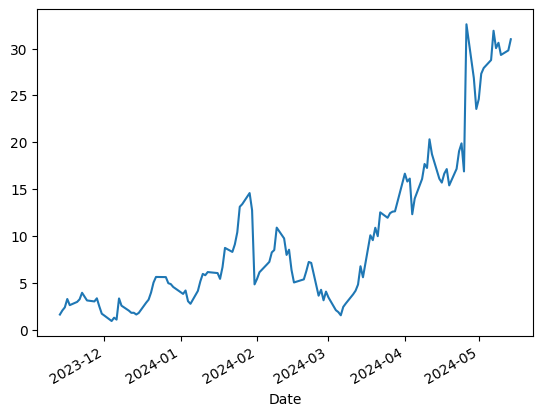

In [ ]:
ejercicio.precio_de_calls_a.plot()

In [ ]:
ejercicio['precio_de_calls_b'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], 140, x['IRX'], x['Vol. GOOGL'], 60), axis=1)


<ipython-input-61-8db7824d71c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ejercicio['precio_de_calls_b'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], 140, x['IRX'], x['Vol. GOOGL'], 60), axis=1)


<Axes: xlabel='Date'>

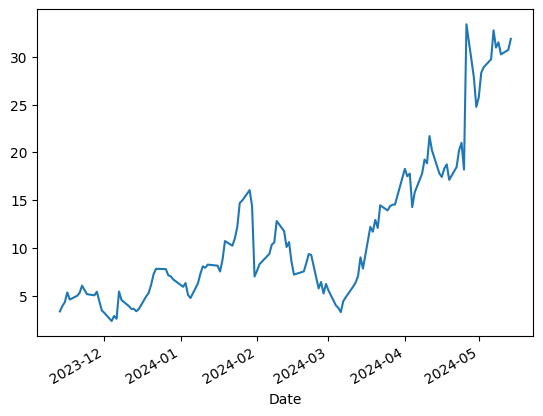

In [ ]:
ejercicio.precio_de_calls_b.plot()

In [ ]:
ejercicio

Ticker,GOOGL,IRX,Vol. GOOGL,log_ret,precio_de_calls,precio_de_calls_a,precio_de_calls_b
Date,,,,,,,
2023-11-13,132.089996,0.05260,0.278241,-0.003778,1.198248,1.638485,3.360242
2023-11-14,133.619995,0.05253,0.277772,0.011516,1.228304,2.073620,3.918692
2023-11-15,134.619995,0.05255,0.277933,0.007456,1.253432,2.405878,4.325773
2023-11-16,136.929993,0.05243,0.277773,0.017014,1.305560,3.297066,5.350941
2023-11-17,135.309998,0.05233,0.277249,-0.011901,1.261290,2.642453,4.602227
...,...,...,...,...,...,...,...
2024-05-08,169.380005,0.05245,0.293484,-0.010980,2.382944,30.038195,30.965508
2024-05-09,169.960007,0.05240,0.292286,0.003418,2.379726,30.611002,31.513408
2024-05-10,168.649994,0.05243,0.291427,-0.007738,2.328201,29.312601,30.253776
